In [54]:
import pandas as pd

# Load tick-level or second-level data
df = pd.read_csv("banknifty_57200.csv", parse_dates=["Timestamp"])

# === Indicators & Derived Columns ===
df["Imbalance"] = (df["BidQty"] - df["AskQty"]) / (df["BidQty"] + df["AskQty"])
df["PrevLTP"] = df["LTP"].shift(1)
df["Price Change %"] = ((df["LTP"] - df["PrevLTP"]) / df["PrevLTP"]) * 100

df["PrevAsk"] = df["AskQty"].shift(1)
df["Prev2Ask"] = df["AskQty"].shift(2)
df["PrevBid"] = df["BidQty"].shift(1)
df["Prev2Bid"] = df["BidQty"].shift(2)

df["Signal"] = 0  # No signal initially

# === Smart Buy Entry: Signal = 1 ===
for i in range(2, len(df)):
    if df.loc[i, "Imbalance"] > 0.3:
        df.loc[i, "Signal"] = 1

# === Smart Sell Entry: Signal = -1 ===
for i in range(2, len(df)):
    if df.loc[i, "Imbalance"] < -0.3:
        df.loc[i, "Signal"] = -1

# === SL/TP Settings ===
TP = 2.5       # Target profit per trade
SL = -0.20     # Stop loss per trade
max_hold_ticks = 5  # How many ticks to hold max

trades = []

# === Trade Simulation ===
for i in range(len(df)):
    signal = df.loc[i, "Signal"]
    if signal != 0:
        entry_price = df.loc[i, "LTP"]
        entry_time = df.loc[i, "Timestamp"]

        for j in range(1, max_hold_ticks + 1):
            if i + j >= len(df):
                break
            exit_price = df.loc[i + j, "LTP"]

            # Calculate PnL based on trade direction
            pnl = (exit_price - entry_price) * signal

            if pnl >= TP or pnl <= SL or j == max_hold_ticks:
                trades.append({
                    "EntryTime": entry_time,
                    "EntryPrice": entry_price,
                    "ExitTime": df.loc[i + j, "Timestamp"],
                    "ExitPrice": exit_price,
                    "PnL": pnl,
                    "Side": "Buy" if signal == 1 else "Sell"
                })
                break  # Exit the trade loop

# === Performance Evaluation ===
trades_df = pd.DataFrame(trades)

if not trades_df.empty:
    win_rate = (trades_df["PnL"] > 0).mean() * 100
    avg_profit = trades_df["PnL"].mean()
    avg_loss = trades_df[trades_df["PnL"] < 0]["PnL"].mean()

    print(f"📊 Total Trades (Buy+Sell): {len(trades_df)}")
    print(f"✅ Win Rate: {win_rate:.2f}%")
    print(f"💰 Avg Profit per Trade: {avg_profit:.4f}")
    print(f"📉 Avg Loss per Trade: {avg_loss:.4f}")

    print("\n📈 Buy Trades:", len(trades_df[trades_df['Side'] == 'Buy']))
    print("📉 Sell Trades:", len(trades_df[trades_df['Side'] == 'Sell']))
else:
    print("No trades met the conditions.")

# === Save Results to CSV ===
trades_df.to_csv("HFT_trades.csv", index=False)

print("🔄 Total Net PnL:", trades_df["PnL"].sum())

📊 Total Trades (Buy+Sell): 2468
✅ Win Rate: 33.95%
💰 Avg Profit per Trade: -0.1017
📉 Avg Loss per Trade: -1.1745

📈 Buy Trades: 1081
📉 Sell Trades: 1387
🔄 Total Net PnL: -250.99999999999943


Total Trades: 76
Total PnL: 206.05
Win Rate: 93.42 %
Average Profit: 2.99
Average Loss: -1.31


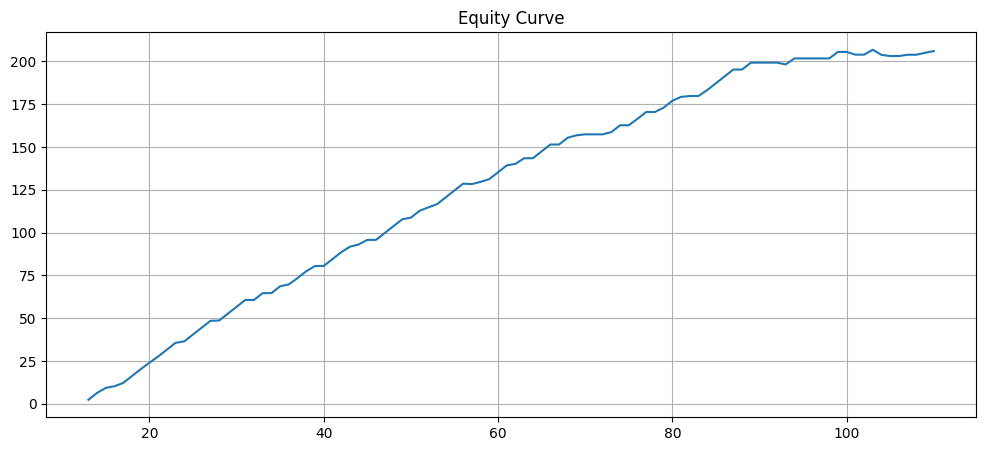

['final_trading_model.csv']

In [122]:
# ML-Based Trading Strategy with Confidence Thresholds, SL/TP, and Short Strategy

import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import joblib

# 1. Load and Resample Data
df = pd.read_csv("banknifty_57200.csv")
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.sort_values('Timestamp').reset_index(drop=True)

# Resample to 1-minute candles
df.set_index('Timestamp', inplace=True)
df = df.resample('1min').agg({
    'LTP': 'last',
    'Volume': 'sum',
    'OI': 'last',
    'LastQty': 'sum',
    'BidQty': 'mean',
    'AskQty': 'mean'
}).dropna().reset_index()

# 2. Add Features
df['LTP_1diff'] = df['LTP'].diff()
df['LTP_3diff'] = df['LTP'].diff(3)
df['LTP_5mean'] = df['LTP'].rolling(window=5).mean()
df['Volume_3mean'] = df['Volume'].rolling(window=3).mean()
df['OI_3mean'] = df['OI'].rolling(window=3).mean()
df['BidAskRatio'] = (df['BidQty'] + 1) / (df['AskQty'] + 1)

def compute_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(period).mean()
    rs = gain / (loss + 1e-6)
    return 100 - (100 / (1 + rs))

df['RSI'] = compute_rsi(df['LTP'])
df = df.dropna()

# 3. Target Creation
df['Future_LTP'] = df['LTP'].shift(-1)
df['Target'] = (df['Future_LTP'] - df['LTP'] > 0.5).astype(int)
df = df.dropna()

# 4. Train Model
features = ['LTP', 'LTP_1diff', 'LTP_3diff', 'LTP_5mean', 'Volume', 'Volume_3mean', 'OI', 'OI_3mean', 'BidAskRatio', 'RSI']
X = df[features]
y = df['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)
model = HistGradientBoostingClassifier(max_iter=200, max_depth=4)
model.fit(X_train, y_train)

# 5. Predict and Trade with Confidence Thresholds
prob_up = model.predict_proba(X)[:, 1]
df['Long_Prob'] = prob_up
df['Short_Prob'] = 1 - prob_up

df['Long_Entry'] = (df['Long_Prob'] > 0.7).astype(int)
df['Short_Entry'] = (df['Short_Prob'] > 0.7).astype(int)

# 6. Backtest with SL/TP
entry_price = df['LTP']
exit_price = df['Future_LTP']
df['Raw_PnL'] = exit_price - entry_price

# Take Profit & Stop Loss
take_profit = 4
stop_loss = -3

pnl = []
position = []

for i in range(len(df)):
    if df['Long_Entry'].iloc[i] == 1:
        move = df['Raw_PnL'].iloc[i]
        if move >= take_profit:
            pnl.append(take_profit)
        elif move <= stop_loss:
            pnl.append(stop_loss)
        else:
            pnl.append(move)
        position.append('Long')
    elif df['Short_Entry'].iloc[i] == 1:
        move = -df['Raw_PnL'].iloc[i]
        if move >= take_profit:
            pnl.append(take_profit)
        elif move <= stop_loss:
            pnl.append(stop_loss)
        else:
            pnl.append(move)
        position.append('Short')
    else:
        pnl.append(0)
        position.append('None')

# Finalize

df['Position'] = position
df['PnL'] = pnl
df['Traded'] = df['PnL'] != 0

# Metrics
wins = df[df['PnL'] > 0]
losses = df[df['PnL'] < 0]
total_trades = df['Traded'].sum()
total_pnl = df['PnL'].sum()
win_rate = len(wins) / total_trades * 100 if total_trades > 0 else 0
avg_profit = wins['PnL'].mean() if not wins.empty else 0
avg_loss = losses['PnL'].mean() if not losses.empty else 0

print(f"Total Trades: {total_trades}")
print(f"Total PnL: {total_pnl:.2f}")
print(f"Win Rate: {win_rate:.2f} %")
print(f"Average Profit: {avg_profit:.2f}")
print(f"Average Loss: {avg_loss:.2f}")

# 7. Plot Equity Curve
df['Equity'] = df['PnL'].cumsum()
df['Equity'].plot(title='Equity Curve', figsize=(12, 5))
plt.grid()
plt.show()

# 8. Save Model
joblib.dump(model, "final_trading_model.csv")

Total Trades: 52
Total PnL: 95.80
Win Rate: 71.15 %
Average Profit: 3.85
Average Loss: -3.10


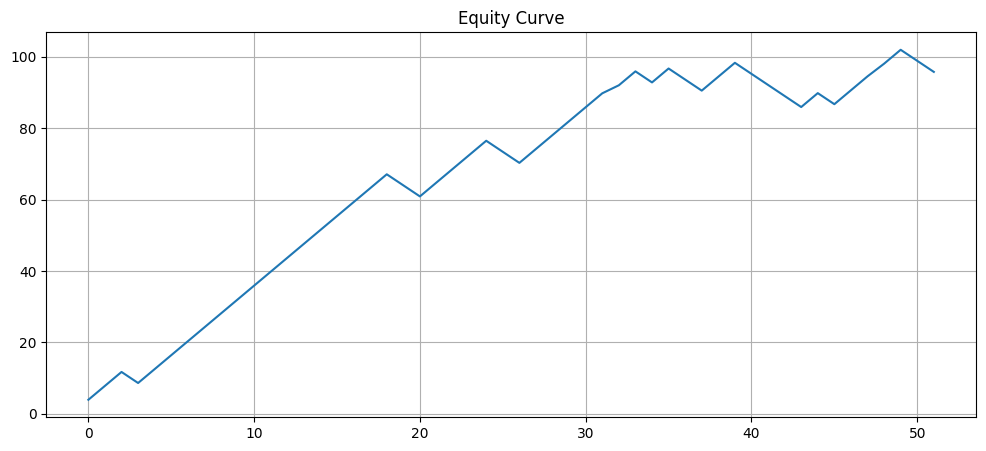

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import joblib

# 1. Load and Resample Data
df = pd.read_csv("11JUN/banknifty_56800.csv")
df = df[-25000:]
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.sort_values('Timestamp').reset_index(drop=True)

# Resample to 1-minute candles
df.set_index('Timestamp', inplace=True)
df = df.resample('1min').agg({
    'LTP': 'last',
    'Volume': 'sum',
    'OI': 'last',
    'LastQty': 'sum',
    'BidQty': 'mean',
    'AskQty': 'mean'
}).dropna().reset_index()

# 2. Add Features
df['LTP_1diff'] = df['LTP'].diff()
df['LTP_3diff'] = df['LTP'].diff(3)
df['LTP_5mean'] = df['LTP'].rolling(window=5).mean()
df['Volume_3mean'] = df['Volume'].rolling(window=3).mean()
df['OI_3mean'] = df['OI'].rolling(window=3).mean()
df['BidAskRatio'] = (df['BidQty'] + 1) / (df['AskQty'] + 1)

def compute_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(period).mean()
    rs = gain / (loss + 1e-6)
    return 100 - (100 / (1 + rs))

df['RSI'] = compute_rsi(df['LTP'])
df = df.dropna()

# 3. Target Creation
df['Future_LTP'] = df['LTP'].shift(-1)
df['Target'] = (df['Future_LTP'] - df['LTP'] > 0.5).astype(int)
df = df.dropna()

# 4. Train Model
features = ['LTP', 'LTP_1diff', 'LTP_3diff', 'LTP_5mean', 'Volume', 'Volume_3mean', 'OI', 'OI_3mean', 'BidAskRatio', 'RSI']
X = df[features]
y = df['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)
model = HistGradientBoostingClassifier(max_iter=200, max_depth=4)
model.fit(X_train, y_train)

# 5. Predict probabilities for all data
prob_up = model.predict_proba(X)[:, 1]
df['Long_Prob'] = prob_up

# 6. Long entry signal (prob > 0.7)
df['Long_Entry'] = (df['Long_Prob'] > 0.7).astype(int)

# 7. Backtest with SL/TP (long-only), no overlapping trades
max_holding_bars = 5  # max bars to hold trade
take_profit = 4
stop_loss = -3
slippage = 0.1  # slippage per trade, adjust as needed

trades = []  # to save trade details

i = 0
while i < len(df):
    if df['Long_Entry'].iloc[i] == 1:
        entry_time = df['Timestamp'].iloc[i]
        entry_price = df['LTP'].iloc[i] + slippage  # slippage on entry
        exit_price = None
        trade_pnl = 0
        trade_exited = False
        
        # Look ahead for TP/SL or max holding period exit
        for j in range(i+1, min(i+1+max_holding_bars, len(df))):
            price = df['LTP'].iloc[j]
            move = price - entry_price
            
            if move >= take_profit:
                trade_pnl = take_profit - slippage  # exit slippage
                exit_price = entry_price + take_profit - slippage
                exit_time = df['Timestamp'].iloc[j]
                trade_exited = True
                exit_bar = j
                break
            elif move <= stop_loss:
                trade_pnl = stop_loss - slippage
                exit_price = entry_price + stop_loss - slippage
                exit_time = df['Timestamp'].iloc[j]
                trade_exited = True
                exit_bar = j
                break
        
        if not trade_exited:
            exit_bar = min(i+max_holding_bars, len(df)-1)
            exit_price = df['LTP'].iloc[exit_bar] - slippage
            trade_pnl = exit_price - entry_price
            exit_time = df['Timestamp'].iloc[exit_bar]
        
        # Save trade details
        trades.append({
            'Entry_Time': entry_time,
            'Entry_Price': entry_price,
            'Exit_Time': exit_time,
            'Exit_Price': exit_price,
            'PnL': trade_pnl
        })
        
        i = exit_bar + 1  # skip bars during trade df
    else:
        i += 1

# Convert trades list to DataFrame
trades_df = pd.DataFrame(trades)

# Print metrics
total_trades = len(trades_df)
total_pnl = trades_df['PnL'].sum()
wins = trades_df[trades_df['PnL'] > 0]
losses = trades_df[trades_df['PnL'] < 0]
win_rate = len(wins) / total_trades * 100 if total_trades > 0 else 0
avg_profit = wins['PnL'].mean() if not wins.empty else 0
avg_loss = losses['PnL'].mean() if not losses.empty else 0

print(f"Total Trades: {total_trades}")
print(f"Total PnL: {total_pnl:.2f}")
print(f"Win Rate: {win_rate:.2f} %")
print(f"Average Profit: {avg_profit:.2f}")
print(f"Average Loss: {avg_loss:.2f}")

# Save trades to CSV
trades_df.to_csv('long_only_trades.csv', index=False)

# Optional: Plot equity curve from trades
trades_df['Equity'] = trades_df['PnL'].cumsum()
trades_df['Equity'].plot(title='Equity Curve', figsize=(12,5))
plt.grid()
plt.show()

# Save model
joblib.dump(model, "banknifty_option_model.joblib")

trades_df.to_csv('backtest_trades.csv', index=False)


In [8]:
import pandas as pd
import numpy as np
import joblib

# === Load and Resample Data ===
df = pd.read_csv("11JUN/banknifty_56800.csv")
df = df[15000:]
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.sort_values('Timestamp').reset_index(drop=True)
df.set_index('Timestamp', inplace=True)

df = df.resample('1min').agg({
    'LTP': 'last',
    'Volume': 'sum',
    'OI': 'last',
    'LastQty': 'sum',
    'BidQty': 'mean',
    'AskQty': 'mean'
}).dropna().reset_index()

# === Load Model ===
model = joblib.load('banknifty_option_model.joblib')
print("✅ Model loaded.")

# === Feature Engineering ===
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0).rolling(period).mean()
    loss = -delta.where(delta < 0, 0).rolling(period).mean()
    rs = gain / (loss + 1e-6)
    return 100 - (100 / (1 + rs))

def generate_features(df_window):
    df_window = df_window.copy()
    df_window['LTP_1diff'] = df_window['LTP'].diff()
    df_window['LTP_3diff'] = df_window['LTP'].diff(3)
    df_window['LTP_5mean'] = df_window['LTP'].rolling(5).mean()
    df_window['Volume_3mean'] = df_window['Volume'].rolling(3).mean()
    df_window['OI_3mean'] = df_window['OI'].rolling(3).mean()
    df_window['BidAskRatio'] = (df_window['BidQty'] + 1) / (df_window['AskQty'] + 1)
    df_window['RSI'] = compute_rsi(df_window['LTP'])
    return df_window

# === Simulation Parameters ===
lookback = 30
features = ['LTP', 'LTP_1diff', 'LTP_3diff', 'LTP_5mean',
            'Volume', 'Volume_3mean', 'OI', 'OI_3mean',
            'BidAskRatio', 'RSI']

take_profit = 4
stop_loss = -2
slippage = 0.1
max_hold = 5  # max candles

# === Live Simulation with Trades ===
trades = []
i = lookback

while i < len(df):
    # Skip if not enough history
    window = df.iloc[i - lookback: i + 1].copy()
    window = generate_features(window).dropna()
    if len(window) == 0:
        i += 1
        continue

    row = window.iloc[-1]
    X_live = row[features].values.reshape(1, -1)
    prob_up = model.predict_proba(X_live)[0, 1]

    if prob_up > 0.7:
        entry_time = row['Timestamp']
        entry_price = row['LTP'] + slippage
        exit_price = None
        reason = None

        for j in range(1, max_hold + 1):
            if i + j >= len(df):
                break

            current_price = df.iloc[i + j]['LTP']
            pnl = current_price - entry_price

            if pnl >= take_profit:
                exit_price = current_price - slippage
                reason = 'TP'
                break
            elif pnl <= stop_loss:
                exit_price = current_price - slippage
                reason = 'SL'
                break

        # Exit on max hold
        if exit_price is None and i + max_hold < len(df):
            exit_price = df.iloc[i + max_hold]['LTP'] - slippage
            reason = 'TIME'

        if exit_price is not None:
            trades.append({
                'Entry Time': entry_time,
                'Exit Time': df.iloc[i + j]['Timestamp'] if reason != 'TIME' else df.iloc[i + max_hold]['Timestamp'],
                'Entry Price': entry_price,
                'Exit Price': exit_price,
                'P&L': exit_price - entry_price,
                'Reason': reason
            })

        # Skip overlapping trades
        i += j if reason != 'TIME' else max_hold
    else:
        i += 1

# === Results ===
trades_df = pd.DataFrame(trades)
trades_df.to_csv("simulated_trades.csv", index=False)

wins = trades_df[trades_df['P&L'] > 0]
losses = trades_df[trades_df['P&L'] <= 0]

print("\n📊 Backtest Summary:")
print(f"Total Trades     : {len(trades_df)}")
print(f"Wins             : {len(wins)}")
print(f"Losses           : {len(losses)}")
print(f"Win Rate         : {len(wins) / len(trades_df) * 100:.2f} %")
print(f"Avg Profit       : {wins['P&L'].mean():.2f}")
print(f"Avg Loss         : {losses['P&L'].mean():.2f}")
print(f"Net P&L          : {trades_df['P&L'].sum():.2f}")

print("\n✅ Simulation complete. Trades saved to 'simulated_trades.csv'")

✅ Model loaded.


/Users/hmaheshwari/Documents/AngelOne Live Data/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but HistGradientBoostingClassifier was fitted with feature names
  warnings.warn(
/Users/hmaheshwari/Documents/AngelOne Live Data/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but HistGradientBoostingClassifier was fitted with feature names
  warnings.warn(
/Users/hmaheshwari/Documents/AngelOne Live Data/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but HistGradientBoostingClassifier was fitted with feature names
  warnings.warn(
/Users/hmaheshwari/Documents/AngelOne Live Data/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but HistGradientBoostingClassifier was fitted with feature names
  warnings.warn(
/Use


📊 Backtest Summary:
Total Trades     : 35
Wins             : 20
Losses           : 15
Win Rate         : 57.14 %
Avg Profit       : 6.95
Avg Loss         : -8.25
Net P&L          : 15.35

✅ Simulation complete. Trades saved to 'simulated_trades.csv'


/Users/hmaheshwari/Documents/AngelOne Live Data/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but HistGradientBoostingClassifier was fitted with feature names
  warnings.warn(
/Users/hmaheshwari/Documents/AngelOne Live Data/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but HistGradientBoostingClassifier was fitted with feature names
  warnings.warn(
/Users/hmaheshwari/Documents/AngelOne Live Data/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but HistGradientBoostingClassifier was fitted with feature names
  warnings.warn(
/Users/hmaheshwari/Documents/AngelOne Live Data/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but HistGradientBoostingClassifier was fitted with feature names
  warnings.warn(
/Use

In [3]:
from SmartApi.smartWebSocketV2 import SmartWebSocketV2
from SmartApi.smartConnect import SmartConnect
from logzero import logger
import pyotp
import time
from datetime import datetime, timedelta
import threading
import requests
AUTH_TOKEN = "IV7PPFHDE4RAWYS7OOXQIBLKTI"
API_KEY = "gsS3VOae"
CLIENT_CODE = "AAAJ289396"
PASS = "5689"
totp_secret = "IV7PPFHDE4RAWYS7OOXQIBLKTI"
totp = pyotp.TOTP(totp_secret)
otp = totp.now()

tick_data = []
bot_token = "8021458974:AAH_U6vWbr877Cv669Ig88MFqWVUWZtf5Mk"
chat_id = 5609562789
url = f"https://api.telegram.org/bot{bot_token}/sendMessage"
message = "Test message from Python ✅"
data = {
    "chat_id": chat_id,
    "text": message
}
response = requests.post(url, data=data)
print(response.status_code)
print(response.text)

200
{"ok":true,"result":{"message_id":5,"from":{"id":8021458974,"is_bot":true,"first_name":"Trading Signals","username":"Trading_signal_alerts_bot"},"chat":{"id":5609562789,"first_name":"Hardik","username":"Hardik_GenOne","type":"private"},"date":1750220413,"text":"Test message from Python \u2705"}}


In [6]:
import requests

# URL for Angel One Instrument Master
url = "https://margincalculator.angelbroking.com/OpenAPI_File/files/OpenAPIScripMaster.json"
data = requests.get(url).json()

# List of NIFTY 50 symbols (as per June 2025)
nifty50_symbols = {
    "RELIANCE", "TCS", "HDFCBANK", "ICICIBANK", "INFY", "KOTAKBANK", "LT",
    "SBIN", "AXISBANK", "ITC", "BHARTIARTL", "HCLTECH", "BAJFINANCE", "ASIANPAINT",
    "MARUTI", "SUNPHARMA", "ULTRACEMCO", "TITAN", "ONGC", "JSWSTEEL", "WIPRO", "TECHM",
    "NESTLEIND", "BRITANNIA", "TATASTEEL", "HINDUNILVR", "NTPC", "POWERGRID", "BPCL",
    "COALINDIA", "ADANIPORTS", "SHREECEM", "DIVISLAB", "EICHERMOT", "GRASIM", "HEROMOTOCO",
    "HINDALCO", "M&M", "DRREDDY", "SBILIFE", "INDUSINDBK", "BAJAJFINSV", "HDFCLIFE",
    "TATACONSUM", "UPL", "CIPLA", "IOC"
}
new_tickers = []
for i in nifty50_symbols:
    new_tickers.append(f"{i}-EQ")


symbol_map = {}

for item in data:
    symbol = item.get("symbol", "")
    token = item.get("token", "")
    exchange = item.get("exch_seg", "")
    
    if symbol in new_tickers and exchange == "NSE":
        symbol_map[token] = symbol

print(symbol_map)


{'10940': 'DIVISLAB-EQ', '11532': 'ULTRACEMCO-EQ', '1348': 'HEROMOTOCO-EQ', '1594': 'INFY-EQ', '17963': 'NESTLEIND-EQ', '11630': 'NTPC-EQ', '13538': 'TECHM-EQ', '1394': 'HINDUNILVR-EQ', '14977': 'POWERGRID-EQ', '11483': 'LT-EQ', '10604': 'BHARTIARTL-EQ', '1363': 'HINDALCO-EQ', '15083': 'ADANIPORTS-EQ', '16675': 'BAJAJFINSV-EQ', '1624': 'IOC-EQ', '1660': 'ITC-EQ', '11287': 'UPL-EQ', '10999': 'MARUTI-EQ', '11536': 'TCS-EQ', '11723': 'JSWSTEEL-EQ', '1232': 'GRASIM-EQ', '3506': 'TITAN-EQ', '1333': 'HDFCBANK-EQ', '1922': 'KOTAKBANK-EQ', '2885': 'RELIANCE-EQ', '3432': 'TATACONSUM-EQ', '467': 'HDFCLIFE-EQ', '20374': 'COALINDIA-EQ', '317': 'BAJFINANCE-EQ', '236': 'ASIANPAINT-EQ', '5258': 'INDUSINDBK-EQ', '5900': 'AXISBANK-EQ', '3103': 'SHREECEM-EQ', '3351': 'SUNPHARMA-EQ', '3045': 'SBIN-EQ', '526': 'BPCL-EQ', '3499': 'TATASTEEL-EQ', '4963': 'ICICIBANK-EQ', '2031': 'M&M-EQ', '21808': 'SBILIFE-EQ', '2475': 'ONGC-EQ', '3787': 'WIPRO-EQ', '547': 'BRITANNIA-EQ', '910': 'EICHERMOT-EQ', '881': 'DRRED